# heart_attack_prediction_analysis

In [27]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from matplotlib.cbook import boxplot_stats

In [3]:
df = pd.read_csv(os.path.join(os.getcwd(),'heart.csv'))

In [4]:
print('This DataFrame has {} rows and {} columns'.format(df.shape[0],df.shape[1]))
df.head(5)

This DataFrame has 303 rows and 14 columns


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### <font color='red'>Data Cleaning</font>

In [8]:
print('{}\n'.format(df.dtypes))

x = ['Found null values' if df.isnull == True else 'Did not find null values']
print('\nChecking for Null: {}'.format(x[0]))

print('\nCheck if there is any duplicates: {}'.format(df.duplicated().any()))

if df.duplicated().any() == True:
    df.drop_duplicates(inplace=True)

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
output        int64
dtype: object


Checking for Null: Did not find null values

Check if there is any duplicates: False


### <font color='red'>Data exploration</font>

<AxesSubplot:title={'center':'Counts of target label'}, xlabel='output', ylabel='count'>

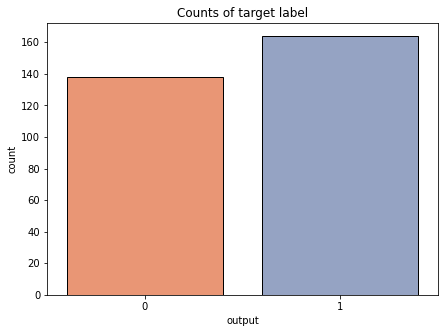

In [9]:
#draw counts plot 
fig = plt.figure(figsize=(7,5))
plt.title('Counts of target label')
counts_table = df.output
sns.countplot(x= counts_table,  palette=['#fc8d62', '#8da0cb'], edgecolor='k')

### accuracy can work as class distribution is symmetric

count    302.00000
mean      54.42053
std        9.04797
min       29.00000
25%       48.00000
50%       55.50000
75%       61.00000
max       77.00000
Name: age, dtype: float64

Coefficient of variation (CV) shows: Small STD


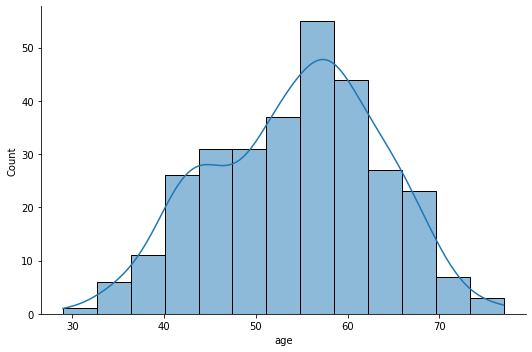

In [17]:
sns.displot(df['age'], aspect = 1.5, kde=True)
print(df['age'].describe())
# As a rule of thumb, a CV >= 1 indicates a relatively high variation, with CV = std/mean
cv = ['Small STD' if df['age'].describe()[2]/df['age'].describe()[1] < 1 else 'High STD']
print('\nCoefficient of variation (CV) shows: {}'.format(cv[0]))

#### The majority of people included in our sample are ranging most from 44 to nearly 68.

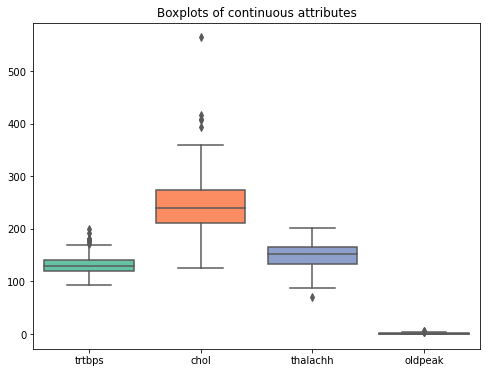

In [20]:
# Drawing boxplot to observe outliers

fig = plt.figure(figsize=(8,6))
plt.title('Boxplots of continuous attributes')
attributes = ['trtbps', 'chol', 'thalachh', 'oldpeak' ]
data = df[attributes]
sns.boxplot(data=data, palette='Set2',saturation=1)
plt.show()

#### Cholesterol seem to have some extreme outliers

In [28]:
# remove rows from heart_df dataframe with 'chol' outliers

chol_outliers = boxplot_stats(df['chol'])[0]['fliers']
df = df[~df['chol'].isin(chol_outliers)]

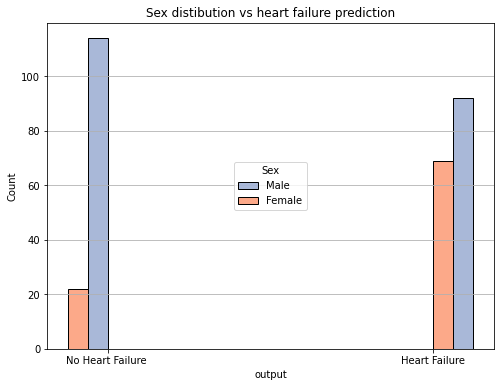

In [29]:
#plot the distributioin of sexes against the target label

fig, axs = plt.subplots(1, 1, figsize=(8,6))
plt.title('Sex distibution vs heart failure prediction')
plt.xticks(ticks = [0.1,0.9], labels=['No Heart Failure ','Heart Failure'] )
sns.histplot(data= df, x = 'output', hue='sex', legend=False,
            palette=['#fc8d62', '#8da0cb'], multiple='dodge', ax=axs)
plt.legend(title='Sex', loc='center', labels=['Male', 'Female'])
axs.grid(axis='y')
plt.show()

In [30]:
#### Creating a correlation matrix to check for multicolliniarity

corr = df.corr(method="pearson")
corr.style.background_gradient(cmap='Blues')

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.074602,-0.066591,0.284392,0.170318,0.117054,-0.097949,-0.403864,0.104076,0.199731,-0.162728,0.304985,0.060216,-0.231584
sex,-0.074602,1.000000,-0.057130,-0.052922,-0.122949,0.051018,-0.087396,-0.040707,0.140218,0.120191,-0.041842,0.128889,0.228731,-0.288353
cp,-0.066591,-0.057130,1.000000,0.053847,-0.088574,0.087168,0.039520,0.294945,-0.393833,-0.139743,0.111069,-0.189053,-0.159387,0.428845
trtbps,0.284392,-0.052922,0.053847,1.000000,0.142433,0.177944,-0.112744,-0.048559,0.071112,0.190092,-0.123919,0.090764,0.064305,-0.143787
chol,0.170318,-0.122949,-0.088574,0.142433,1.000000,0.007385,-0.099409,-0.027480,0.099355,0.007787,0.026398,0.079922,0.071063,-0.112667
fbs,0.117054,0.051018,0.087168,0.177944,0.007385,1.000000,-0.082233,-0.008471,0.029863,0.011824,-0.071037,0.149165,-0.025208,-0.035228
restecg,-0.097949,-0.087396,0.039520,-0.112744,-0.099409,-0.082233,1.000000,0.046088,-0.074527,-0.044702,0.086093,-0.076680,-0.002643,0.139110
thalachh,-0.403864,-0.040707,0.294945,-0.048559,-0.027480,-0.008471,0.046088,1.000000,-0.377274,-0.349145,0.387842,-0.231558,-0.097087,0.421106
exng,0.104076,0.140218,-0.393833,0.071112,0.099355,0.029863,-0.074527,-0.377274,1.000000,0.295739,-0.258124,0.124413,0.206192,-0.432968
oldpeak,0.199731,0.120191,-0.139743,0.190092,0.007787,0.011824,-0.044702,-0.349145,0.295739,1.000000,-0.576810,0.221430,0.198741,-0.427227


#### Checking for Multicollinearity<br>
As a rule of thump correlation should be above 0.7

In [31]:
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        if i!=j and corr.iloc[i,j] > 0.7:
            x = 'There is Multicolliniarity'
        else:
            x = 'No Multicolliniarity'
x

'No Multicolliniarity'

### <font color='red'>Machine Learning</font>

In [ ]:
# Some function used as helper for the section

def ChangeFromNumericalToBinary(row):
    if row >= 0.5:
        return 1
    else:
        return 0
    
def calculateMatrix(y_test,y_pred):
    return accuracy_score(y_test,y_pred), \
           precision_score(y_test,y_pred), \
           recall_score(y_test,y_pred), \
           f1_score(y_test,y_pred)

def printMatrixResults(accuracy, recall, precision, f1_score):
    print('\nAccuracy: {:.4}%'.format(str(accuracy*100)))
    print('recall: {:.4}%'.format(str(recall*100)))
    print('precision: {:.4}%'.format(str(precision*100)))
    print('f1 score: {:.4}%'.format(str(f1_score*100)))

#### Ordinary least squares Linear Regression (OLS)

Treating the problem as a regression task, thresholding the predictions at 0.5

In [32]:
x_ols = df.loc[:,'age':'thall']
x_ols = sm.add_constant(x_ols)
X_train, X_test, y_train, y_test = train_test_split(x_ols, df['output'], random_state=1)
model = sm.OLS(y_train, X_train)
model_trained = model.fit()
print(model_trained.summary())
predictions = model_trained.predict(X_test).astype(int)
binary_predictions = predictions.apply(ChangeFromNumericalToBinary)
accuracy_ols, precision_ols, recall_ols, f_one_ols = calculateMatrix(y_test,binary_predictions)
printMatrixResults(accuracy_ols, recall_ols, precision_ols, f_one_ols)

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.532
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     18.20
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           8.15e-28
Time:                        17:04:06   Log-Likelihood:                -75.501
No. Observations:                 222   AIC:                             179.0
Df Residuals:                     208   BIC:                             226.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0299      0.349      2.949      0.0

One way to improve our model is backward elimination<br>
We remove all the independant variables with a p-value > 0.05 as they are not statistically significant.


In [33]:
list_with_values_ols_2 = ['const','sex','cp','thalachh','exng','oldpeak','slp','caa','thall']

model_ols_2 = sm.OLS(y_train, X_train[list_with_values_ols_2])
model_trained_ols_2 = model_ols_2.fit()

print(model_trained_ols_2.summary())
predictions = model_trained_ols_2.predict(X_test[list_with_values_ols_2]).astype(int)
binary_predictions_ols_2 = predictions.apply(ChangeFromNumericalToBinary)
accuracy_ols_2, precision_ols_2, recall_ols_2, f_one_ols_2 = calculateMatrix(y_test, binary_predictions_ols_2)
printMatrixResults(accuracy_ols_2, 
                            recall_ols_2, 
                            precision_ols_2, 
                            f_one_ols_2)
# very small changes indicate that the elimination proccess is not effective.
# Thus, this model is inefficient.

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     28.53
Date:                Thu, 30 Dec 2021   Prob (F-statistic):           6.25e-30
Time:                        17:04:09   Log-Likelihood:                -78.981
No. Observations:                 222   AIC:                             176.0
Df Residuals:                     213   BIC:                             206.6
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5253      0.209      2.517      0.0

All metrics are still low. The problem can not be treated as regression task.

In [34]:
x = df.loc[:,'age':'thall']
X_train, X_test, y_train, y_test = train_test_split(x, df['output'], random_state=1)
scaled_values_train = StandardScaler().fit_transform(X_train, y=None)
scaled_values_test = StandardScaler().fit_transform(X_test, y=None)

#### LogisticRegression

In [35]:
model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy_log_reg, precision_log_reg, recall_log_reg, f_one_log_reg = calculateMatrix(y_test, y_pred)
printMatrixResults(accuracy_log_reg, 
                            recall_log_reg, 
                            precision_log_reg, 
                            f_one_log_reg)


Accuracy: 81.3%
recall: 84.2%
precision: 80.0%
f1 score: 82.0%


Already the score of the model has improved.

#### Support Vector Machine Linear

In [36]:
model_fit = LinearSVC(max_iter=10000).fit(X_train, y_train) 

C:\Users\ypsilantis\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Running again the same model with scaled data

In [37]:
model_fit = LinearSVC(max_iter=10000).fit(scaled_values_train, y_train)
y_pred = model_fit.predict(scaled_values_test)
accuracy_svm_lin, precision_svm_lin, recall_svm_lin, f_one_lin = calculateMatrix(y_test, y_pred)
printMatrixResults(accuracy_svm_lin,
                            precision_svm_lin,
                            recall_svm_lin,
                            f_one_lin)


Accuracy: 84.0%
recall: 78.2%
precision: 94.7%
f1 score: 85.7%


Linear SVM shows better score that logistic regression.

#### Support Vector Machine RBF

In [38]:
model_fit = SVC(gamma='scale',C=0.1).fit(scaled_values_train, y_train)
y_pred = model_fit.predict(scaled_values_test)
accuracy_svm_rbf, precision_svm_rbf, recall_svm_rbf, f_one_rbf = calculateMatrix(y_test, y_pred)
printMatrixResults(accuracy_svm_rbf, precision_svm_rbf, recall_svm_rbf, f_one_rbf)


Accuracy: 80.0%
recall: 73.4%
precision: 94.7%
f1 score: 82.7%


Linear kernel is still the best.

#### MLP Classifier

In [39]:
# check hidden_layer_sizes
# 100 neurones kai 4 layers

model_fit = MLPClassifier(random_state=1,
                          max_iter=100000,
                          hidden_layer_sizes=(100,4)).fit(X_train,y_train)

y_pred = model_fit.predict(X_test)

accuracy_MLP, precision_MLP, recall_MLP, f_one_MLP = calculateMatrix(y_test, y_pred)
printMatrixResults(accuracy_MLP, precision_MLP, recall_MLP, f_one_MLP)


Accuracy: 78.6%
recall: 75.0%
precision: 86.8%
f1 score: 80.4%


#### Summary:<br>
The aim of this project was to find the best model for predicting heart attack.
Models used:<br>
* Ordinary least squares Linear Regression (OLS)
* LogisticRegression
* Support Vector Machine Linear
* Support Vector Machine RBF
* MLP Classifier

The best prediction came from Support Vector Machine RBF (using StandardScaler for the independant variables).